# Effect of Text-Audio Pre-Training

CLAP consists of an audio encoder and a text encoder. The audio encoder is a [CNN14](https://github.com/qiuqiangkong/audioset_tagging_cnn) encoder, pre-trained on the [AudioSet](https://research.google.com/audioset/) classification task.
The text encoder is [HuggingFace's BERT-base-uncased](https://huggingface.co/google-bert/bert-base-uncased), pre-trained on [BookCorpus](https://yknzhu.wixsite.com/mbweb) and the [English Wikipedia](https://en.wikipedia.org/wiki/English_Wikipedia).

These encoders, along with some projection matrices are trained to output a 1024-dimensional embedding, where in matching inputs to the text and audio encoders result in embeddings that are close together in the embedding space. This is done using the contrastive learning framework.

In this notebook, we investigate the effect of the text-audio / language-audio pre-training on both encoders, using the instances and classes from the [ESC-50](https://github.com/karolpiczak/ESC-50) dataset.

## Index
- [Initialization](#initialization)
- [Text Encoder](#text-encoder)
- [Audio Encoder](#audio-encoder)

## Initialization

This section contains necessary setup for the experiment. It can usually be collapsed and the experiment can still be understood without poring over these details.

- [Imports and hyperparameters](#imports-and-hyperparameters)
- [Seeding randomness](#seeding-randomness)
- [Loading the model and dataset](#loading-the-model-and-dataset)

### Imports and hyperparameters

In [1]:
from CLAPWrapper import CLAPWrapper
from esc50_dataset import ESC50
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
from tqdm.notebook import tqdm
from icecream import ic
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 50

### Seeding randomness
This is to seed any and all randomness that might be present in the model.  \
This **should** only be the dropout layers in between the projection matrices, and a random sample
of the audio to be taken if the model's input audio duration, does **not** match with
the dataset's input audio duration.

The dropout layers should be deactivated after turning the model to evaluation mode, and
CLAP 's expected audio duration does match with ESC-50's audio duration (5 seconds), so this shouldn't matter,
but better to be safe than sorry.


In [3]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [4]:
seed_everything(42)

### Loading the model and dataset


#### Loading weights
Microsoft has made the pre-trained weights for CLAP available for download on request [here](https://zenodo.org/record/7312125#.Y22vecvMIQ9).

In [5]:
weights_path = "/scratch/pratyaksh.g/clap/CLAP_weights_2022_microsoft.pth"
clap_model = CLAPWrapper(weights_path, use_cuda=True if DEVICE == "cuda" else False)

In [6]:
clap_model.clap.eval()

CLAP(
  (audio_encoder): AudioEncoder(
    (base): Cnn14(
      (spectrogram_extractor): Spectrogram(
        (stft): STFT(
          (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
          (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
        )
      )
      (logmel_extractor): LogmelFilterBank()
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block1): ConvBlock(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_block2): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

#### Loading dataset
We use the [ESC-50 dataset](https://github.com/karolpiczak/ESC-50), which consists of 2000 recordings across 50 classes of environmental sounds, each 5 seconds long.

In [7]:
dataset = ESC50(root="/scratch/pratyaksh.g/esc50/", download=False)

Using downloaded and verified file: /scratch/pratyaksh.g/esc50/ESC-50-master.zip


2000it [00:00, 12056.81it/s]

Loading audio files


### Utility functions

In [15]:
def heatmap(x, y, xlabel='', ylabel='', title='', order=None):
    # Function to calculate cosine similarity between two vectors
    def cosine_similarity(vec1, vec2):
        dot_product = np.dot(vec1, vec2)
        norm_vec1 = np.linalg.norm(vec1)
        norm_vec2 = np.linalg.norm(vec2)
        return dot_product / (norm_vec1 * norm_vec2)

    # labels = dataset.classes
    labels = temporal_relations
    size = len(labels)

    # Calculate pairwise similarities between vectors in both groups
    similarity_matrix = np.zeros((size, size))  # Initialize a matrix to store the similarities

    # Reorder x, y and dataset.classes by order
    if order:
        x = x[order]
        y = y[order]
        labels = [dataset.classes[x] for x in order]

    for i in range(size):
        for j in range(size):
            similarity_matrix[i, j] = cosine_similarity(y[i], x[j])

    fig = px.imshow(
        similarity_matrix, x=labels, y=labels, title=title,
        labels={'x': xlabel, 'y': ylabel, 'color': 'Cosine Similarity'},
    )

    fig.update_layout(width=1000, height=1000)

    fig.show()

In [9]:
def get_dendrogram_order(enc, pretrain=True):
    if enc == 'text':
        embeddings = pretrain_embedded_text if pretrain else no_pretrain_embedded_text
        embeddings = embeddings.detach().cpu().numpy()
    elif enc == 'audio':
        embeddings = pretrain_embedded_audios if pretrain else no_pretrain_embedded_audios
    else:
        raise ValueError('Invalid encoder')

    R = dendrogram(linkage(embeddings, method='ward', metric='euclidean'), labels=dataset.classes, no_plot=True)

    return R['leaves']

## Text Encoder

First, we set up the templates for the text prompts, which are of the form `'this is a sound of <class-name>'`.
We only care about the `CLS` tokens from the text encoder.

In [10]:
prompt = 'this is a sound of '
text = [prompt + class_name for class_name in dataset.classes]
preprocessed_text = clap_model.preprocess_text(text)

for key, val in preprocessed_text.items():
    preprocessed_text[key] = val.to(DEVICE)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home2/pratyaksh.g/miniconda3/envs/ms-clap/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [20]:
prompt_before = 'a clock ticking '
prompt_after = ' a siren blaring'
temporal_relations = ['followed by', 'then', 'after', 'before']
text = [prompt_before + relation + prompt_after for relation in temporal_relations]
preprocessed_text = clap_model.preprocess_text(text)

for key, val in preprocessed_text.items():
    preprocessed_text[key] = val.to(DEVICE)

/home2/pratyaksh.g/miniconda3/envs/ms-clap/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



### **Without** language-audio pre-training

In [21]:
%%capture
# Load the bert base uncased model and tokenizer, put them to eval mode on the gpu, and wrap them in a function
bert_model = BertModel.from_pretrained('bert-base-uncased').to(DEVICE)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model.eval()

In [22]:
no_pretrain_embedded_text = bert_model(**preprocessed_text)[0]
no_pretrain_embedded_text = no_pretrain_embedded_text[:, 0, :] # CLS token embeddings

In [23]:
heatmap(no_pretrain_embedded_text.detach().cpu().numpy(),
        no_pretrain_embedded_text.detach().cpu().numpy(),
        xlabel='No Pretrain',
        ylabel='No Pretrain',
        title='Text Embedding Cosine Self Similarity (No Pretrain)',
        # order=get_dendrogram_order('text', pretrain=False))
)

In [36]:
# Select indices for 10 random classes from the dataset
indices = np.random.choice(50, 10, replace=False)

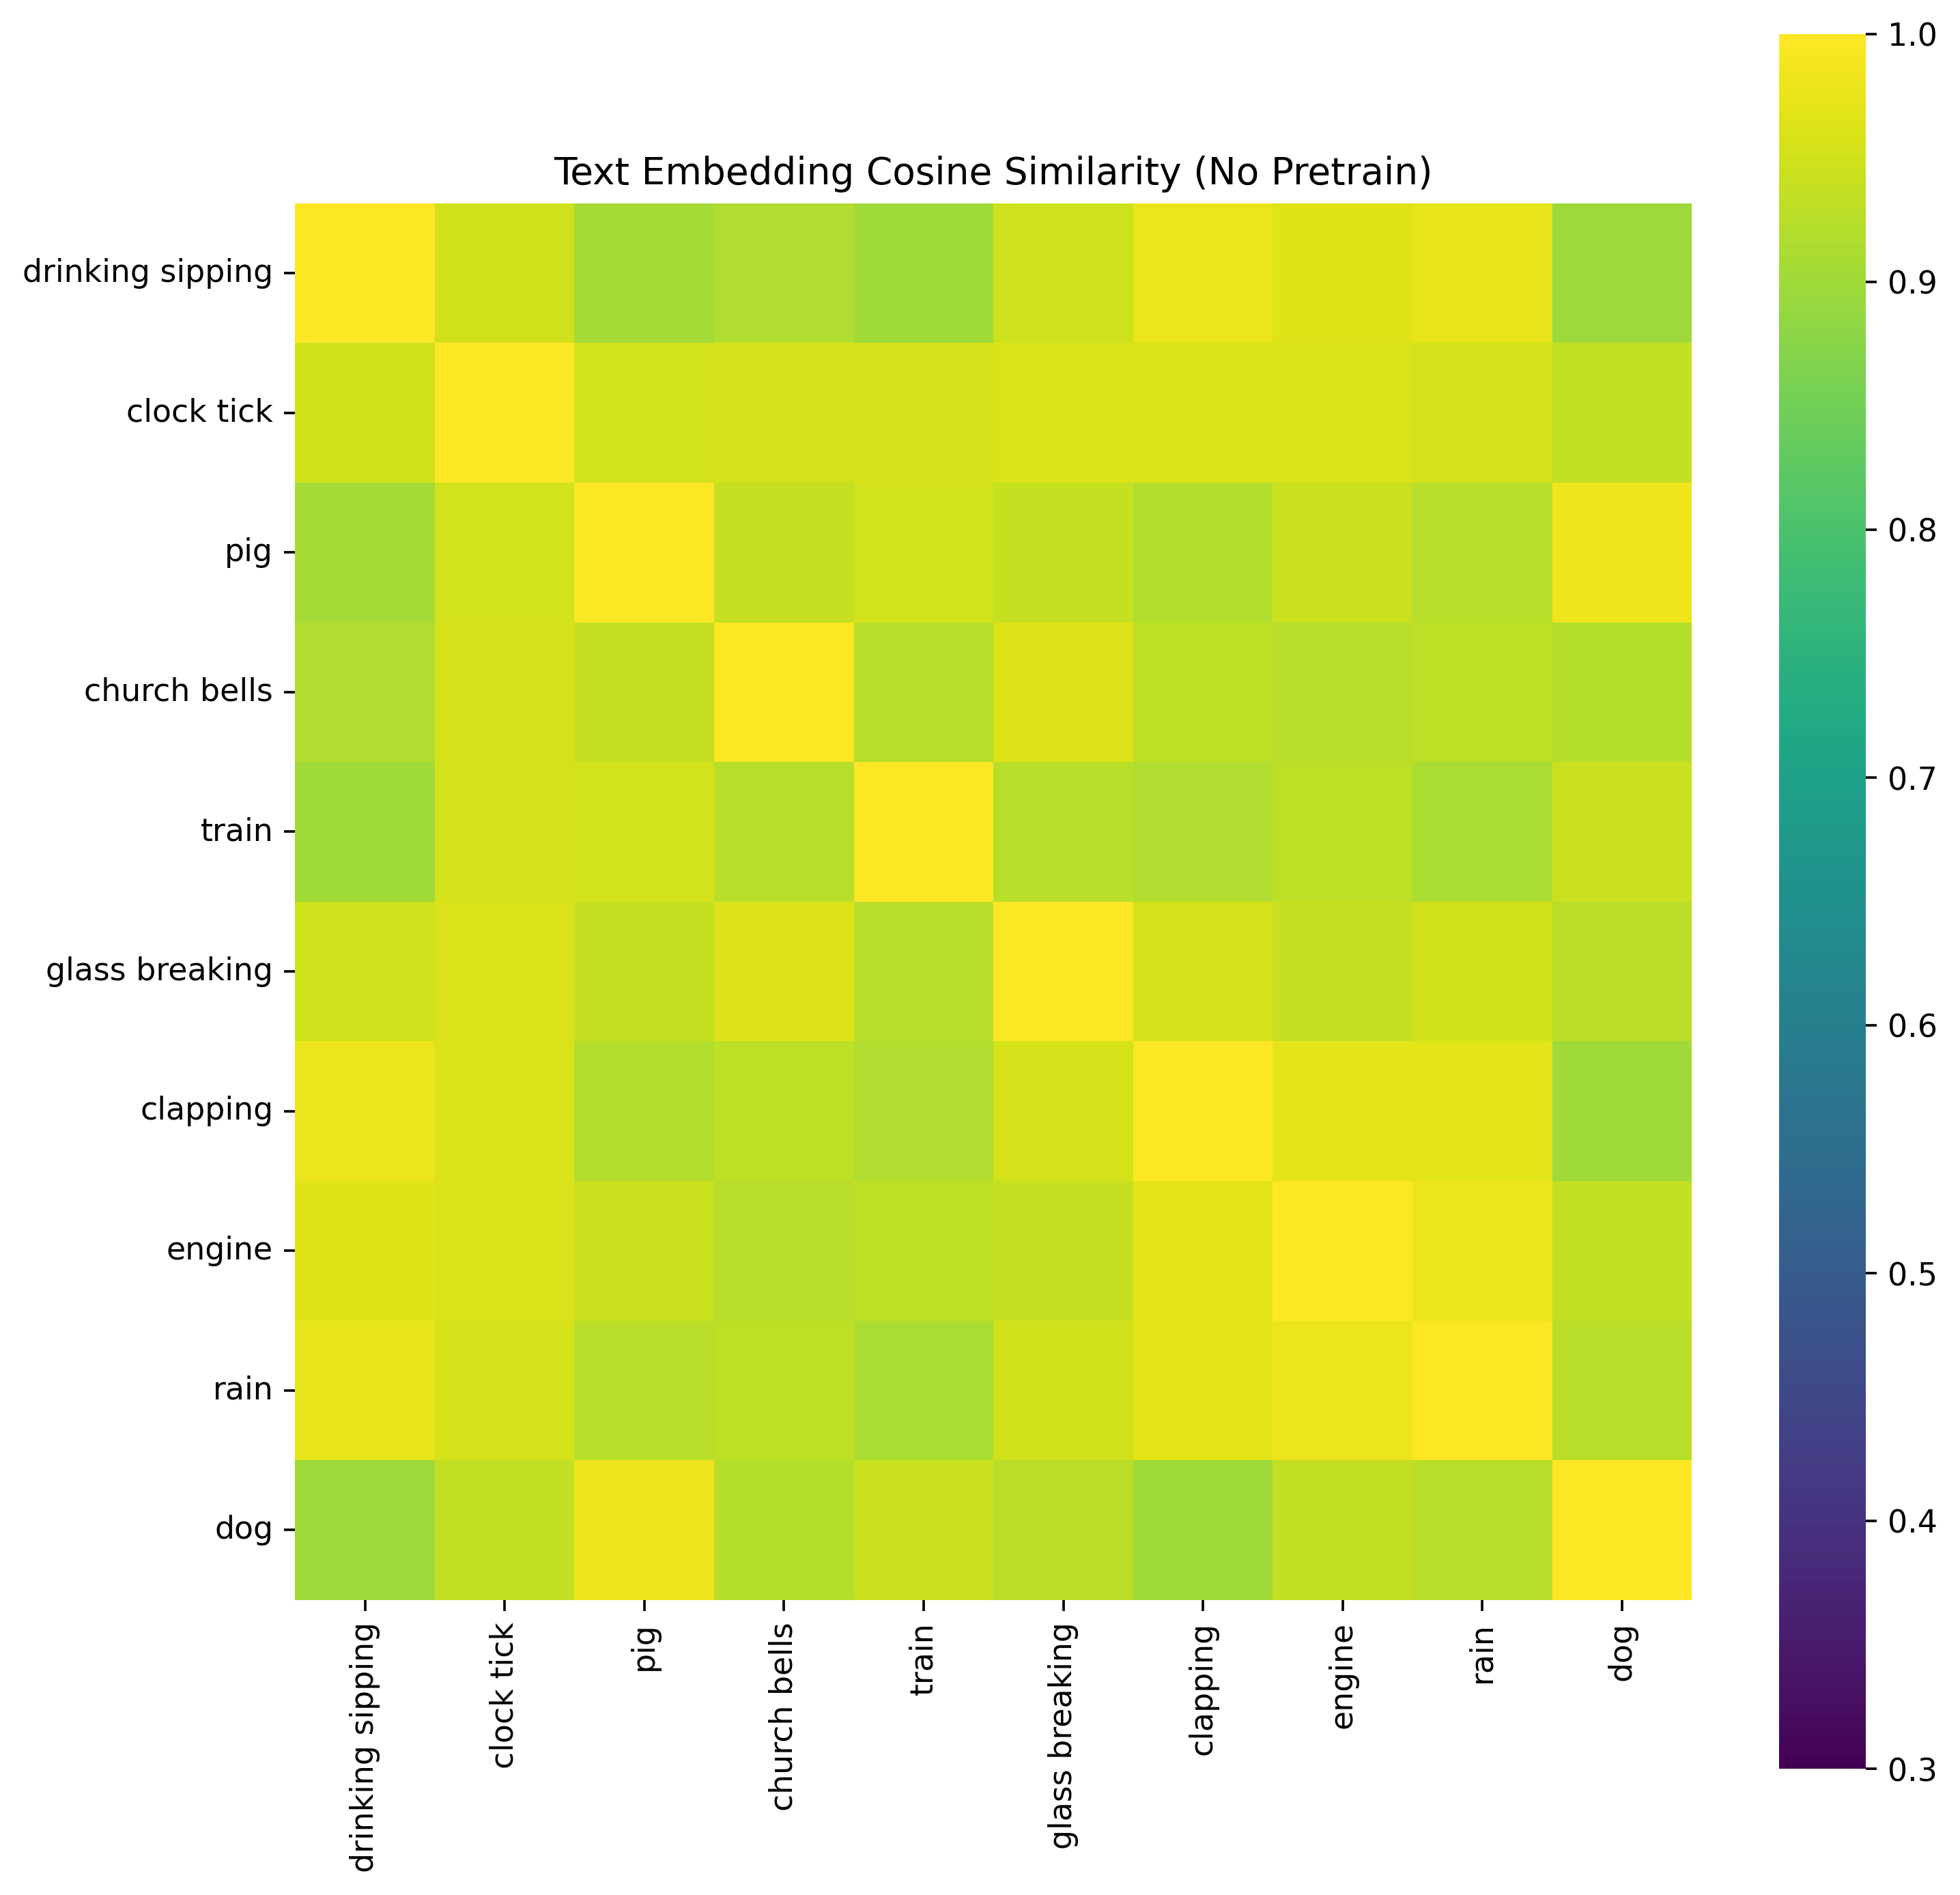

In [37]:
# Using seaborn, make a heatmap for just these 10 classes
# First, get the class names for the selected indices
class_names = [dataset.classes[i] for i in indices]

# Next, get the embeddings for these classes
selected_text_embeddings = no_pretrain_embedded_text[indices]

# Then compute the cosine similarities between the embeddings
similarity_matrix = torch.zeros((10, 10), device=DEVICE)

def cosine_similarity(x, y):
    dot_product = torch.dot(x, y)
    norm_x = torch.linalg.norm(x)
    norm_y = torch.linalg.norm(y)
    return dot_product / (norm_x * norm_y)

for i in range(10):
    for j in range(10):
        similarity_matrix[i, j] = cosine_similarity(selected_text_embeddings[i], selected_text_embeddings[j])

# Next, put this into a dataframe
df = pd.DataFrame(similarity_matrix.detach().cpu().numpy(), index=class_names, columns=class_names)

# Finally plot it using sns.heatmap
plt.figure(figsize=(10, 10), dpi=330)
sns.heatmap(df, annot=False, cmap='viridis', cbar=True, square=True, vmin=0.3, vmax=1)
plt.title('Text Embedding Cosine Similarity (No Pretrain)')
plt.show()


### **With** language-audio pre-training

In [24]:
%%capture
clap_model.clap.caption_encoder.base.to(DEVICE)

In [25]:
pretrain_embedded_text = clap_model.clap.caption_encoder.base(**preprocessed_text)[0]
pretrain_embedded_text = pretrain_embedded_text[:, 0, :]

In [26]:
heatmap(pretrain_embedded_text.detach().cpu().numpy(),
        pretrain_embedded_text.detach().cpu().numpy(),
        xlabel='Pretrain',
        ylabel='Pretrain',
        title='Text Embedding Cosine Self Similarity (Pretrain)',
        # order=get_dendrogram_order('text', pretrain=False))
)

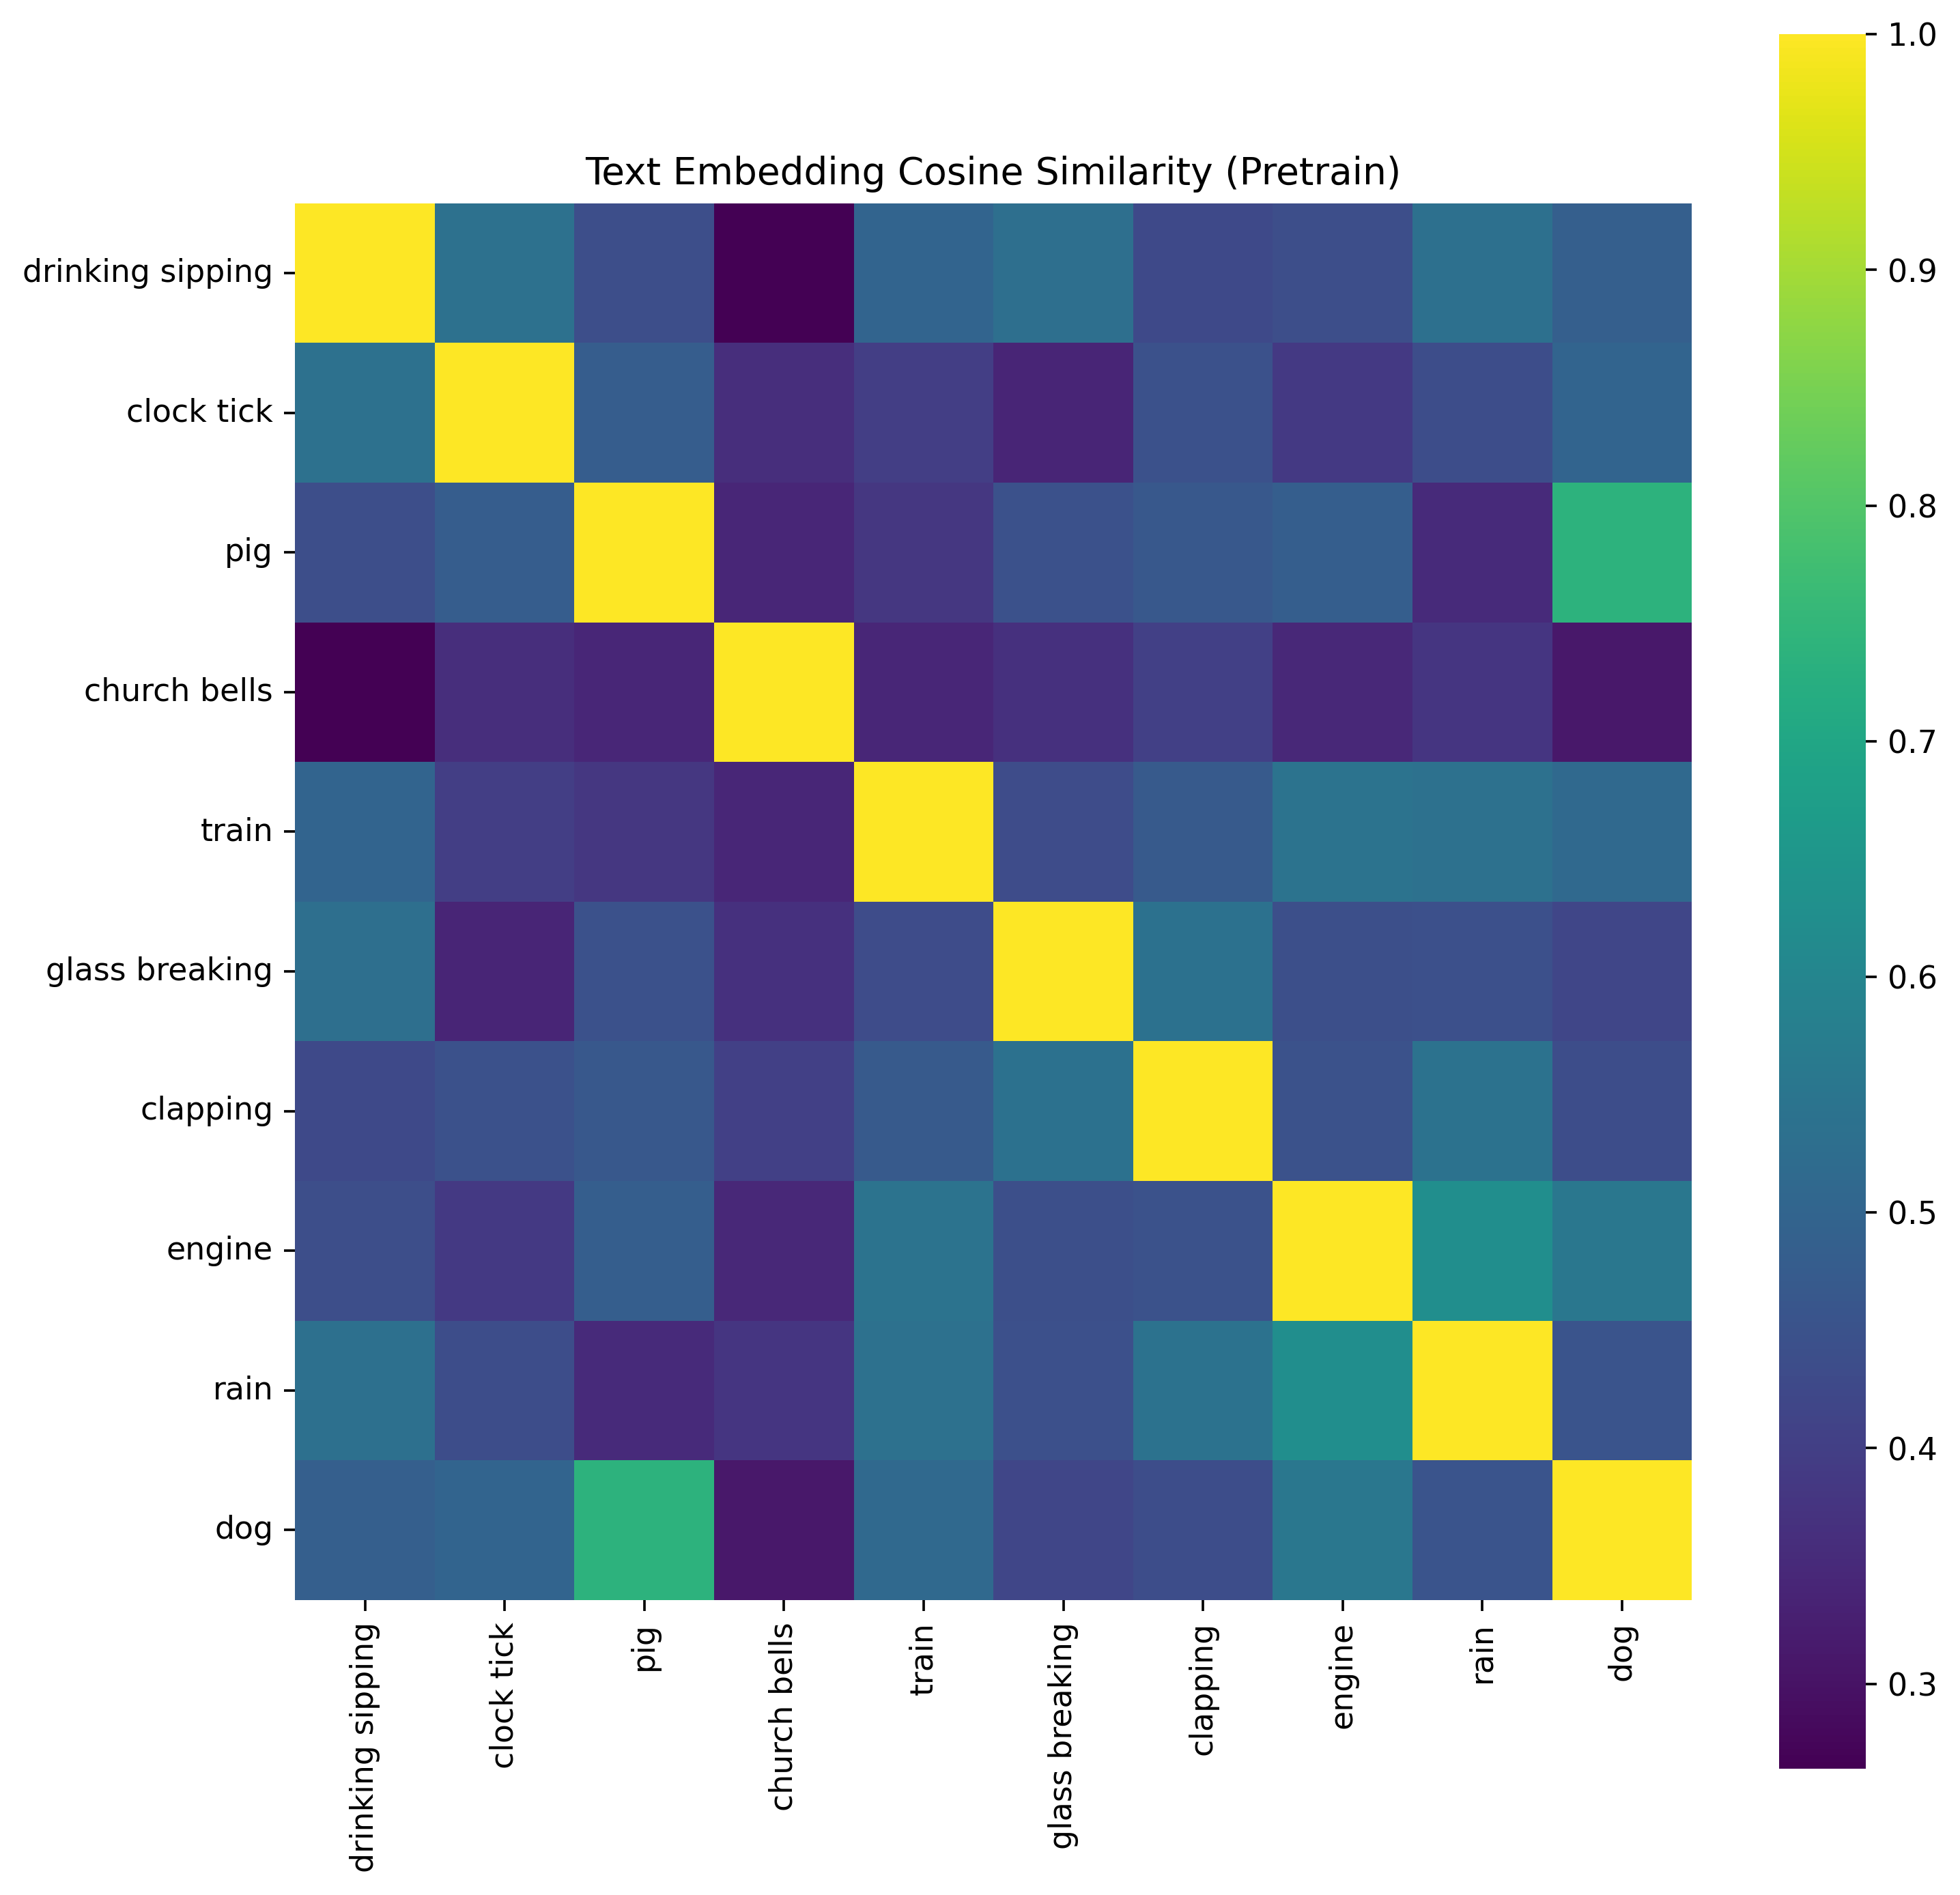

In [38]:
# Using seaborn, make a heatmap for just these 10 classes
# First, get the class names for the selected indices
class_names = [dataset.classes[i] for i in indices]

# Next, get the embeddings for these classes
selected_text_embeddings = pretrain_embedded_text[indices]

# Then compute the cosine similarities between the embeddings
similarity_matrix = torch.zeros((10, 10), device=DEVICE)

def cosine_similarity(x, y):
    dot_product = torch.dot(x, y)
    norm_x = torch.linalg.norm(x)
    norm_y = torch.linalg.norm(y)
    return dot_product / (norm_x * norm_y)

for i in range(10):
    for j in range(10):
        similarity_matrix[i, j] = cosine_similarity(selected_text_embeddings[i], selected_text_embeddings[j])

# Next, put this into a dataframe
df = pd.DataFrame(similarity_matrix.detach().cpu().numpy(), index=class_names, columns=class_names)

# Finally plot it using sns.heatmap
plt.figure(figsize=(10, 10), dpi=330)
sns.heatmap(df, annot=False, cmap='viridis', cbar=True, square=True)
plt.title('Text Embedding Cosine Similarity (Pretrain)')
plt.show()


## Audio Encoder

### **Without** language-audio pre-training
The CNN14 embeddings for the ESC-50 dataset are pre-computed and directly loaded in. This makes things simpler within this
notebook because they require a separate environment to compute.
> TODO: Add more info.

In [25]:
embeddings = pd.read_csv('/scratch/pratyaksh.g/esc50-cnn14-embeddings-44.1k.csv', index_col=0)
embeddings['embedding'] = embeddings['embedding'].apply(lambda x: x.split('[')[1].split(']')[0].split())
embeddings['embedding'] = embeddings['embedding'].apply(lambda x: [float(y) for y in x])

In [26]:
classwise_embeddings = []

# Take the average audio embedding for each class
for class_idx in range(NUM_CLASSES):
    class_embeddings = embeddings[embeddings['class_idx'] == class_idx]['embedding'].to_list()
    class_embeddings = np.array(class_embeddings)
    class_embeddings = class_embeddings.mean(axis=0)
    classwise_embeddings.append(class_embeddings)

no_pretrain_embedded_audios = np.array(classwise_embeddings)

In [29]:
heatmap(no_pretrain_embedded_audios,
        no_pretrain_embedded_audios,
        xlabel='No Pretrain',
        ylabel='No Pretrain',
        title='Audio Embedding Cosine Self Similarity (No Pretrain)',
        order=get_dendrogram_order('audio', pretrain=False))

### **With** language-audio pre-training 

In [31]:
%%capture
clap_model.clap.audio_encoder.base.to(DEVICE)

In [32]:
embeddings = pd.DataFrame(columns=['patch_idx', 'patch_name', 'class_name', 'class_idx', 'embedding'])

for patch_idx, patch in enumerate(tqdm(dataset)):
    audio_path, class_name, one_hot_target = patch
    class_idx = dataset.class_to_idx[class_name]
    patch_name = audio_path.split('/')[-1].split('.')[0]

    audio = clap_model.preprocess_audio([audio_path], False)
    audio = audio.reshape(audio.shape[0], audio.shape[2])
    audio_embedding = clap_model.clap.audio_encoder.base(audio.to(DEVICE))
    audio_embedding = audio_embedding['embedding'].squeeze().detach().cpu().numpy()

    embeddings.loc[len(embeddings)] = [patch_idx, patch_name, class_name, class_idx, audio_embedding]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [33]:
classwise_embeddings = []

# Take the average audio embedding for each class
for class_idx in range(NUM_CLASSES):
    class_embeddings = embeddings[embeddings['class_idx'] == class_idx]['embedding'].to_list()
    class_embeddings = np.array(class_embeddings)
    class_embeddings = class_embeddings.mean(axis=0)
    classwise_embeddings.append(class_embeddings)

pretrain_embedded_audios = np.array(classwise_embeddings)

In [34]:
heatmap(pretrain_embedded_audios,
        pretrain_embedded_audios,
        xlabel='Pretrain',
        ylabel='Pretrain',
        title='Audio Embedding Cosine Self Similarity (Pretrain)',
        order=get_dendrogram_order('audio', pretrain=True))